In [1]:
import sys
import numpy as np
import scipy
import subprocess
from natsort import natsorted
import itertools
import pandas as pd
sys.path.append("../utls")
sys.path.append("../utls")
sys.path.append("../.")
import os
from utls.preprocessing import *
from utls.postprocessing import *
from InterfaceDeclaration import LPBFInterface
import matplotlib.pyplot as plt
import seaborn as sns

alphabet = list(string.ascii_lowercase)

project_name = ["MuSIC", "MaPS", "MuSIC_EXP1"]
if os.name == "posix":
    data_dir = subprocess.getoutput("echo $DATADIR")
elif os.name == "nt":
    data_dir = subprocess.getoutput("echo %datadir%")
music_dir = os.path.join(data_dir, "MuSIC")
if not os.path.exists(music_dir):
    project_name[0] = "2024-MUSIC"
daq_dir = os.path.join(data_dir, *project_name, "Acoustic Monitoring")
lmq_dir = os.path.join(data_dir, *project_name, "LMQ Monitoring")
del music_dir

sampling_rate_daq: int = int(1.25 * 1e6)
sampling_rate_lmq: int = int(0.1 * 1e6)
tdms_daq_list = natsorted(
    [i for i in os.listdir(daq_dir) if i.split(".")[-1] == "tdms"]
)
bin_lmq_list = natsorted([i for i in os.listdir(lmq_dir) if i.split(".")[-1] == "bin"])
lmq_channel_name = [
    "Vector ID",
    "meltpooldiode",
    "X Coordinate",
    "Y Coordinate",
    "Laser power",
    "Spare",
    "Laser diode",
    "Varioscan(focal length)",
]
process_regime = [
    [0,    59, "Base"  ], 
    [60,  129, "KH"    ], 
    [130, 199, "Normal"], 
    [200, 269, "RLoF"  ], 
    [269, 339, "LoF"   ] 
]

## Accuracy results

### AE

In [2]:
max_epochs=50
his_dir = os.path.join(os.pardir,"lfs","weights/hist")
model_name= ["CNN"]
acoustic_type =['ae','mic'] 
context_type = []
# context_type = ['energy']
output_type = ['direction']
folds = 10

df = generate_hist_df(his_dir,model_name,acoustic_type,context_type,output_type,folds,max_epochs)
df['Input Type'] = df['Input type'].str.replace('+', '\n')
df[df['Input Type']=='ae'].describe(), df[df['Input Type']=='mic'].describe()

(       Train Acc   Test Acc  Fold index        Acc
 count  20.000000  20.000000   20.000000  20.000000
 mean    0.925667   0.859139    4.500000   0.892403
 std     0.143267   0.107023    2.946898   0.130975
 min     0.507359   0.547129    0.000000   0.507359
 25%     0.962764   0.884671    2.000000   0.887727
 50%     0.969627   0.891480    4.500000   0.905702
 75%     0.976946   0.900032    7.000000   0.968935
 max     0.984970   0.906144    9.000000   0.984970,
        Train Acc   Test Acc  Fold index        Acc
 count  20.000000  20.000000   20.000000  20.000000
 mean    0.586199   0.571202    4.500000   0.578701
 std     0.124971   0.120800    2.946898   0.123144
 min     0.225871   0.220524    0.000000   0.220524
 25%     0.598770   0.591702    2.000000   0.597578
 50%     0.633506   0.608935    4.500000   0.615570
 75%     0.638027   0.616937    7.000000   0.633099
 max     0.658419   0.632218    9.000000   0.658419)

C:\Users\mingwucn\AppData\Local\Temp\ipykernel_12488\2235189450.py:5: UserWarning: The palette list has more values (3) than needed (2), which may not be intended.
  ax = sns.violinplot(
C:\Users\mingwucn\AppData\Local\Temp\ipykernel_12488\2235189450.py:21: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([f'{x*100:.0f}\%' for x in ax.get_yticks()[:-2]])
C:\Users\mingwucn\AppData\Local\Temp\ipykernel_12488\2235189450.py:23: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([x for x in xTickLabels])


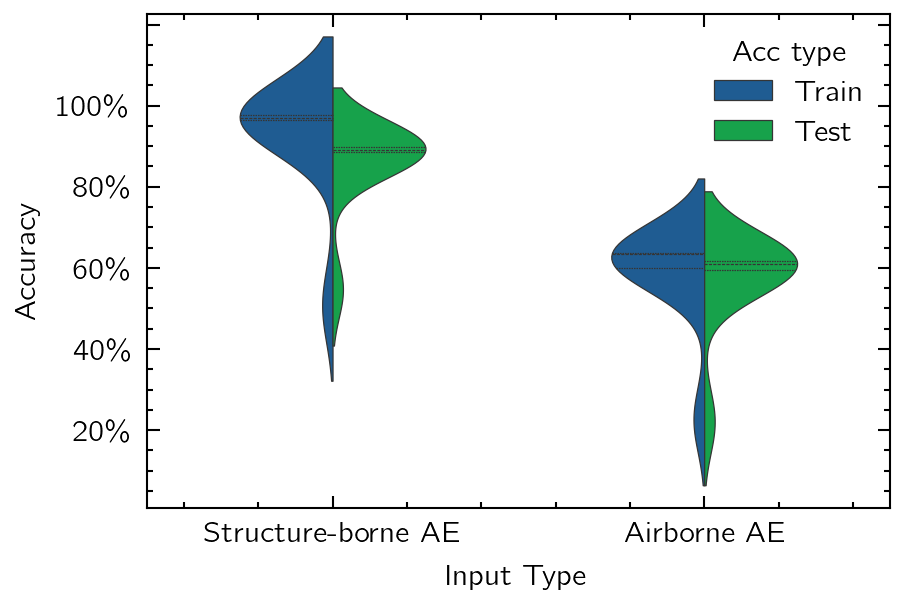

In [3]:
plt.rcParams.update(one_column)
plt.rcParams['figure.constrained_layout.use'] = True
fig,ax = plt.subplots(figsize=(3.0,2))
snsdf = sns.load_dataset("tips")
ax = sns.violinplot(
    data=df[df["Model"]=="CNN"],
    x="Input Type",
    y="Acc",
    hue="Acc type",
    split=True,
    saturation=0.75,
    density_norm="width",
    hue_order=["Train", "Test"],
    dodge=True,
    inner='quartile',
    ax=ax,
    linewidth=0.3,
    width = 0.5,
    palette = ['#0C5DA5', '#00B945', 'yellow'],
)
ax.set_yticklabels([f'{x*100:.0f}\%' for x in ax.get_yticks()[:-2]]) 
xTickLabels = ["Structure-borne AE","Airborne AE"]
ax.set_xticklabels([x for x in xTickLabels]) 
ax.set_ylabel("Accuracy")
plt.savefig(f"../outputs/raw_acc_ae_mic_direction.png",dpi=300)
plt.show()

In [4]:
max_epochs=50
his_dir = os.path.join(os.pardir,"lfs","weights/hist")
model_name= ["CNN"]
acoustic_type =['ae','mic'] 
context_type = []
# context_type = ['energy']
output_type = ['position']
folds = 10

df = generate_hist_df(his_dir,model_name,acoustic_type,context_type,output_type,folds,max_epochs)
df['Input Type'] = df['Input type'].str.replace('+', '\n')
df[df['Input Type']=='ae'].describe(), df[df['Input Type']=='mic'].describe()

(       Train Acc   Test Acc  Fold index        Acc
 count  20.000000  20.000000   20.000000  20.000000
 mean    0.996888   0.996558    4.500000   0.996723
 std     0.000260   0.000546    2.946898   0.000460
 min     0.996149   0.995577    0.000000   0.995577
 25%     0.996899   0.996220    2.000000   0.996482
 50%     0.996966   0.996623    4.500000   0.996913
 75%     0.997006   0.997024    7.000000   0.997011
 max     0.997069   0.997346    9.000000   0.997346,
        Train Acc   Test Acc  Fold index        Acc
 count  20.000000  20.000000   20.000000  20.000000
 mean    0.859849   0.814344    4.500000   0.837097
 std     0.007828   0.012884    2.946898   0.025663
 min     0.845723   0.784864    0.000000   0.784864
 25%     0.855213   0.807463    2.000000   0.820733
 50%     0.859663   0.820331    4.500000   0.836767
 75%     0.863644   0.824192    7.000000   0.859533
 max     0.874014   0.827811    9.000000   0.874014)

C:\Users\mingwucn\AppData\Local\Temp\ipykernel_12488\857493326.py:5: UserWarning: The palette list has more values (3) than needed (2), which may not be intended.
  ax = sns.violinplot(
C:\Users\mingwucn\AppData\Local\Temp\ipykernel_12488\857493326.py:21: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([f'{x*100:.0f}\%' for x in ax.get_yticks()[:-2]])
C:\Users\mingwucn\AppData\Local\Temp\ipykernel_12488\857493326.py:23: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([x for x in xTickLabels])


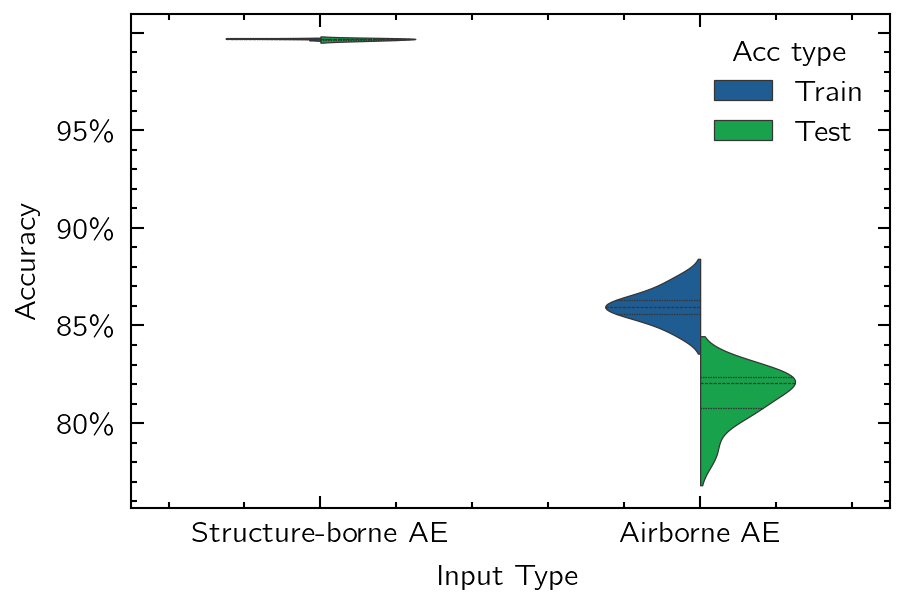

In [5]:
plt.rcParams.update(one_column)
plt.rcParams['figure.constrained_layout.use'] = True
fig,ax = plt.subplots(figsize=(3.0,2))
snsdf = sns.load_dataset("tips")
ax = sns.violinplot(
    data=df[df["Model"]=="CNN"],
    x="Input Type",
    y="Acc",
    hue="Acc type",
    split=True,
    saturation=0.75,
    density_norm="width",
    hue_order=["Train", "Test"],
    dodge=True,
    inner='quartile',
    ax=ax,
    linewidth=0.3,
    width = 0.5,
    palette = ['#0C5DA5', '#00B945', 'yellow'],
)
ax.set_yticklabels([f'{x*100:.0f}\%' for x in ax.get_yticks()[:-2]]) 
xTickLabels = ["Structure-borne AE","Airborne AE"]
ax.set_xticklabels([x for x in xTickLabels]) 
ax.set_ylabel("Accuracy")
plt.savefig(f"../outputs/raw_acc_ae_mic_position.png",dpi=300)
plt.show()

### Mic